<div align="center"><h2>Модель сегрегации Шеллинга</h2></div>

### Импорты

In [1]:
import numpy as np
import random

import matplotlib.pyplot as plt
import matplotlib.colors as col
from matplotlib import animation
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

from copy import deepcopy
from typing import List, Tuple

%matplotlib inline

### Функции

In [2]:
class Person(object):
    def __init__(self, *args, types_count: int, **kwargs) -> None:
        self.type = random.choice([x for x in range(1, types_count + 1)])
        self.happiness = True
    
    def __repr__(self) -> None:
        return f"Person(type={self.type}, self.happiness={self.happiness})"

In [3]:
class Population(object):
    def __init__(self, *args,
                 dimention: int,
                 population_size: int,
                 types_count: int,
                 tolerance_levels: List[float],
                 **kwargs) -> None:
        self.dimention = dimention
        self._population_size = population_size
        self.types_count = types_count
        self._tolerance_levels = tolerance_levels
        
        self._population = [Person(types_count=types_count) for _ in range(population_size)]
        self.grid = np.zeros((dimention, dimention), dtype=Person)
        self._empty_cells = []
        
        self.simulation_results = []
        
    def _initial_empty_cells(self) -> None:
        for i in range(self.dimention):
            for j in range(self.dimention):
                if self.grid[i, j] == 0:
                    self._empty_cells.append((i, j))

    def _initial_configuration(self) -> None:
        grid_positions = [(i, j) for i in range(self.dimention) for j in range(self.dimention)]
        people_positions = random.sample(grid_positions, self._population_size)
        for i in range(len(self._population)):
            self.grid[people_positions[i]] = self._population[i]
        self._initial_empty_cells()
        self.simulation_results = [deepcopy(self.grid)]
        
    def _get_neighbors_position(self, i: int, j: int) -> None:
        function = lambda element: not (element[0] < 0 or element[0] > self.dimention - 1 or \
                                        element[1] < 0 or element[1] > self.dimention - 1)
        return list(filter(function, [(i - 1, j + 1), (i, j + 1), (i + 1, j + 1), (i - 1, j), (i + 1, j), (i - 1, j - 1), (i, j - 1), (i + 1, j - 1)]))
    
    def _agent_happy(self, agent: Person, i: int, j: int) -> None:
        near = 0
        neighbors_positions = self._get_neighbors_position(i, j)
        neighbors = [self.grid[neighbor] for neighbor in neighbors_positions]
        for neighbor in neighbors:
            if neighbor == 0 or neighbor.type == agent.type:
                near += 1
        agent.happiness = near >= self._tolerance_levels[agent.type - 1] * len(neighbors)
        
    def _jump_to_random_empty_cell(self, i: int, j: int) -> None:
        agent = self.grid[i, j]
        new_position = random.choice(self._empty_cells)
        self._empty_cells.remove(new_position)
        self.grid[new_position] = Person(types_count=self.types_count)
        self.grid[new_position].type = agent.type
        self.grid[new_position].happiness = agent.happiness
        self.grid[i, j] = 0
        self._empty_cells.append((i, j))
        
    def simulation(self, iterations_count: int) -> None:
        self._initial_configuration()
        for _ in range(iterations_count):
            for i in range(self.dimention):
                for j in range(self.dimention):
                    if self.grid[i, j] != 0:
                        agent = self.grid[i, j]
                        self._agent_happy(agent, i, j)
                        if not agent.happiness and random.random() > 0.7:
                            self._jump_to_random_empty_cell(i, j)
            self.simulation_results.append(deepcopy(self.grid))
        
    def __repr__(self) -> None:
        return f"Population(dimention={self.dimention}, population_size={self._population_size}, types_count={self.types_count}, tolerance_levels={self._tolerance_levels})"

In [4]:
def plot_population(population: Population, *, colors: List[str]) -> None:
    paint_grid = [[population.grid[i, j].type if population.grid[i, j] != 0 else 0
                   for j in range(population.dimention)]
                   for i in range(population.dimention)]
    cmap = col.ListedColormap(colors)
    plt.figure(figsize=(10,10))
    plt.pcolormesh(paint_grid, edgecolor="black", cmap=cmap)
    plt.show()

In [5]:
def draw_animation(population: Population, *, colors: List[str], step=1) -> HTML:
    fig, ax = plt.subplots(figsize=(10, 10))

    cmap = col.ListedColormap(colors)
    paint_grids = []

    for k in range(kIterations):
        paint_grids.append([[population.simulation_results[k][i, j].type if population.simulation_results[k][i, j] != 0 else 0
                             for j in range(population.dimention)]
                             for i in range(population.dimention)])

    def animate(i):    
        return ax.pcolormesh(paint_grids[i], edgecolor="black", cmap=cmap)

    anim = animation.FuncAnimation(fig, animate, frames=range(0, kIterations, step), blit=False)
    plt.close()
    
    return HTML(anim.to_jshtml())

In [6]:
def _stats(population: Population) -> Tuple[int, int, int]:
    happy, sad = 0, 0

    for i in range(population.dimention):
        for j in range(population.dimention):
            if population.grid[i, j] != 0:
                if population.grid[i, j].happiness:
                    happy += 1
                else:
                    sad += 1
    
    return (happy, sad, happy + sad)

In [7]:
def pie_population(population: Population) -> None:
    happy, sad, _ = _stats(population)
    plt.figure(figsize=(8, 8))
    plt.pie([happy, sad], autopct="%1.1f%%", labels=["Happy", "Sad"])
    plt.title("Соотношение счастья")
    plt.legend()
    plt.show()

### Эксперименты

#### 2 разделяющих признака и равные уровни толерантности

__Гиперпараметры__

In [8]:
kPopulationSize = 8000
kDimention = 100
kTypesCount = 2
kToleranceLevel = [0.65, 0.65]
kIterations = 40

In [9]:
population = Population(dimention=kDimention, population_size=kPopulationSize, types_count=kTypesCount, tolerance_levels=kToleranceLevel)

In [10]:
population.simulation(kIterations)

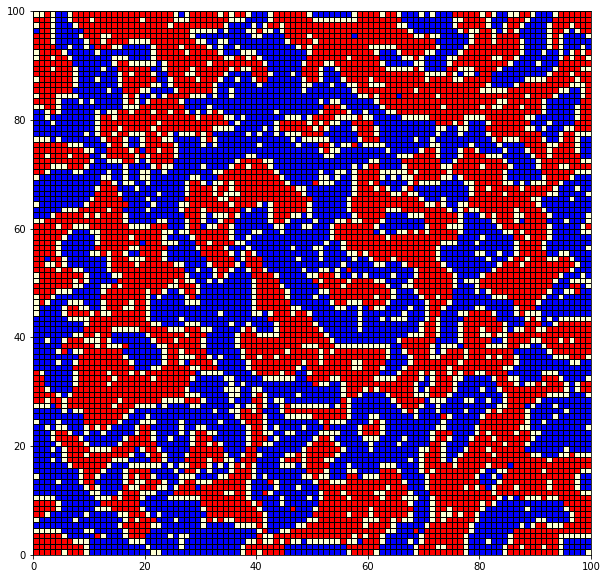

In [11]:
plot_population(population, colors=["#feffd4", "red", "blue"])

In [12]:
draw_animation(population, colors=["#feffd4", "red", "blue"])

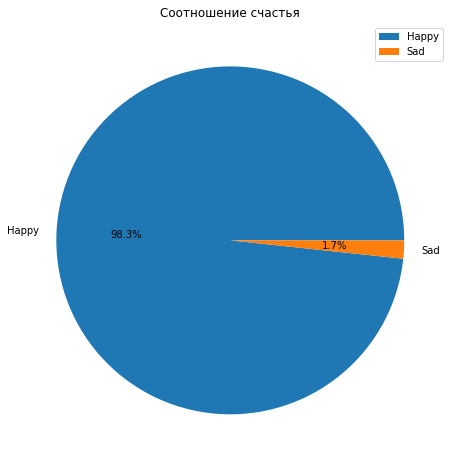

In [13]:
pie_population(population)

#### 2 разделяющих признака и разные уровни толерантности

__Гиперпараметры__

In [14]:
kPopulationSize = 8000
kDimention = 100
kTypesCount = 2
kToleranceLevel = [0.7, 0.3]
kIterations = 80

In [15]:
population = Population(dimention=kDimention, population_size=kPopulationSize, types_count=kTypesCount, tolerance_levels=kToleranceLevel)

In [16]:
population.simulation(kIterations)

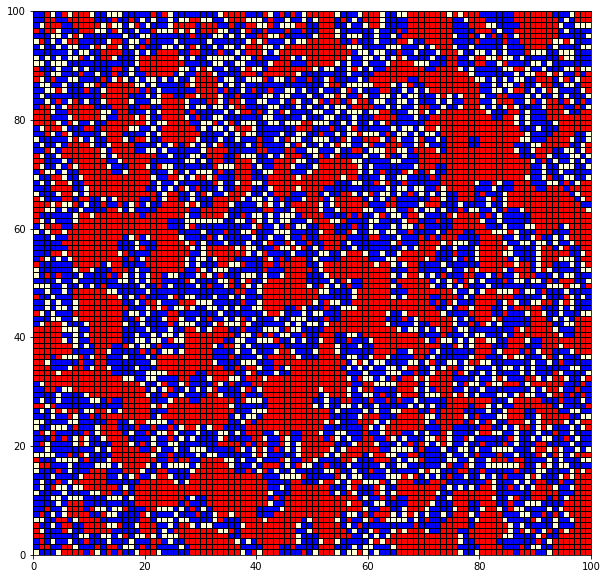

In [17]:
plot_population(population, colors=["#feffd4", "red", "blue"])

In [18]:
draw_animation(population, colors=["#feffd4", "red", "blue"], step=5)

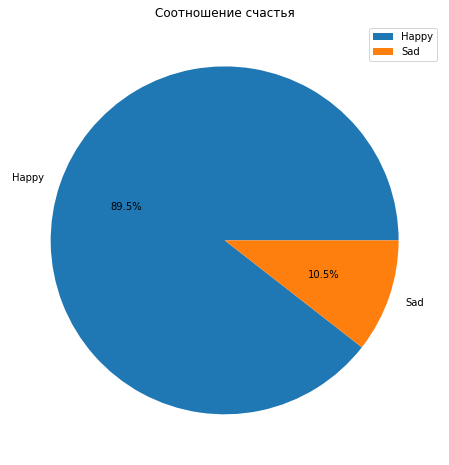

In [19]:
pie_population(population)

#### 3 разделяющих признака и равные уровни толерантности

__Гиперпараметры__

In [20]:
kPopulationSize = 8000
kDimention = 100
kTypesCount = 3
kToleranceLevel = [0.7, 0.7, 0.7]
kIterations = 150

In [21]:
population = Population(dimention=kDimention, population_size=kPopulationSize, types_count=kTypesCount, tolerance_levels=kToleranceLevel)

In [22]:
population.simulation(kIterations)

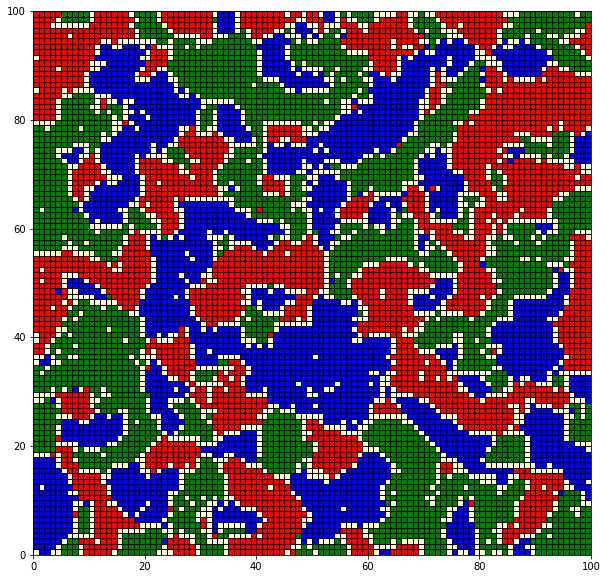

In [23]:
plot_population(population, colors=["#feffd4", "red", "blue", "green"])

In [24]:
draw_animation(population, colors=["#feffd4", "red", "blue", "green"], step=10)

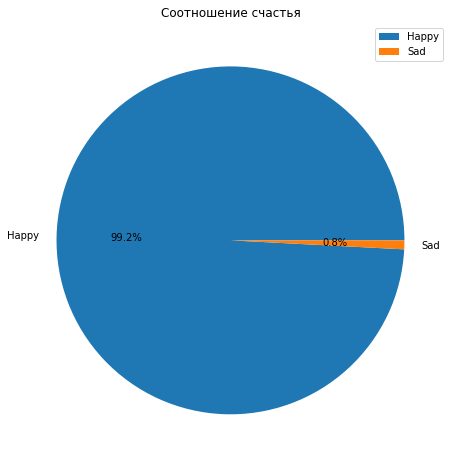

In [25]:
pie_population(population)

#### 3 разделяющих признака и разные уровни толерантности

__Гиперпараметры__

In [26]:
kPopulationSize = 8000
kDimention = 100
kTypesCount = 3
kToleranceLevel = [0.7, 0.5, 0.4]
kIterations = 100

In [27]:
population = Population(dimention=kDimention, population_size=kPopulationSize, types_count=kTypesCount, tolerance_levels=kToleranceLevel)

In [28]:
population.simulation(kIterations)

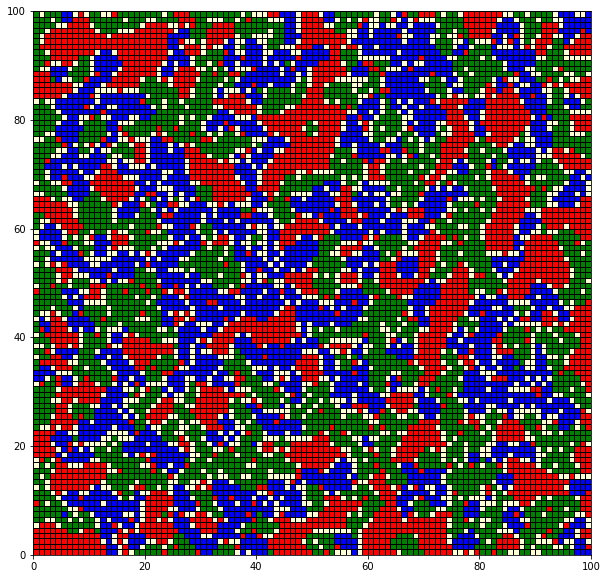

In [29]:
plot_population(population, colors=["#feffd4", "red", "blue", "green"])

In [30]:
draw_animation(population, colors=["#feffd4", "red", "blue", "green"], step=5)

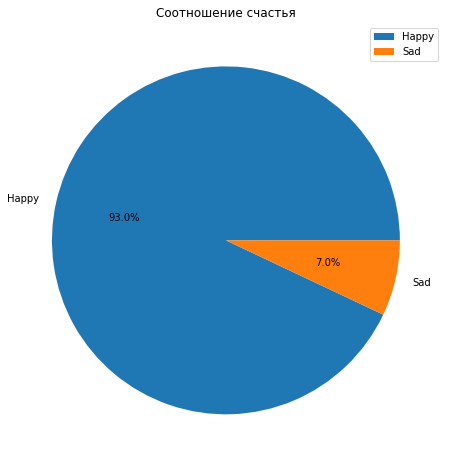

In [31]:
pie_population(population)